# Extend Thunder with CUDA-Python

In this demo, we implement a (naive, unoptimized) version of the flash attention 2 algorithm from 
[Tri Dao: FlashAttention-2: Faster Attention with Better Parallelism and Work Partitioning](https://tridao.me/publications/flash2/flash2.pdf), following this pseudocode which we took from the paper.

Our implementation won't be quite as fast as flash attention, but we will learn how to use a CUDA kernel from Python/PyTorch/Thunder by extending Thunder with NVIDIA's [CUDA-Python](https://github.com/NVIDIA/cuda-python) low-level bindings, and then you can do it for your own, even more awesome kernels.

There is not much special about the Thunder part of this, so if you looked at the extending Thunder section in the [Zero to Thunder tutorial](./zero_to_thunder.ipynb) things should look very familiar, but as CUDA-Python is relatively new, we thought it might be neat to have a spelled-out example here.

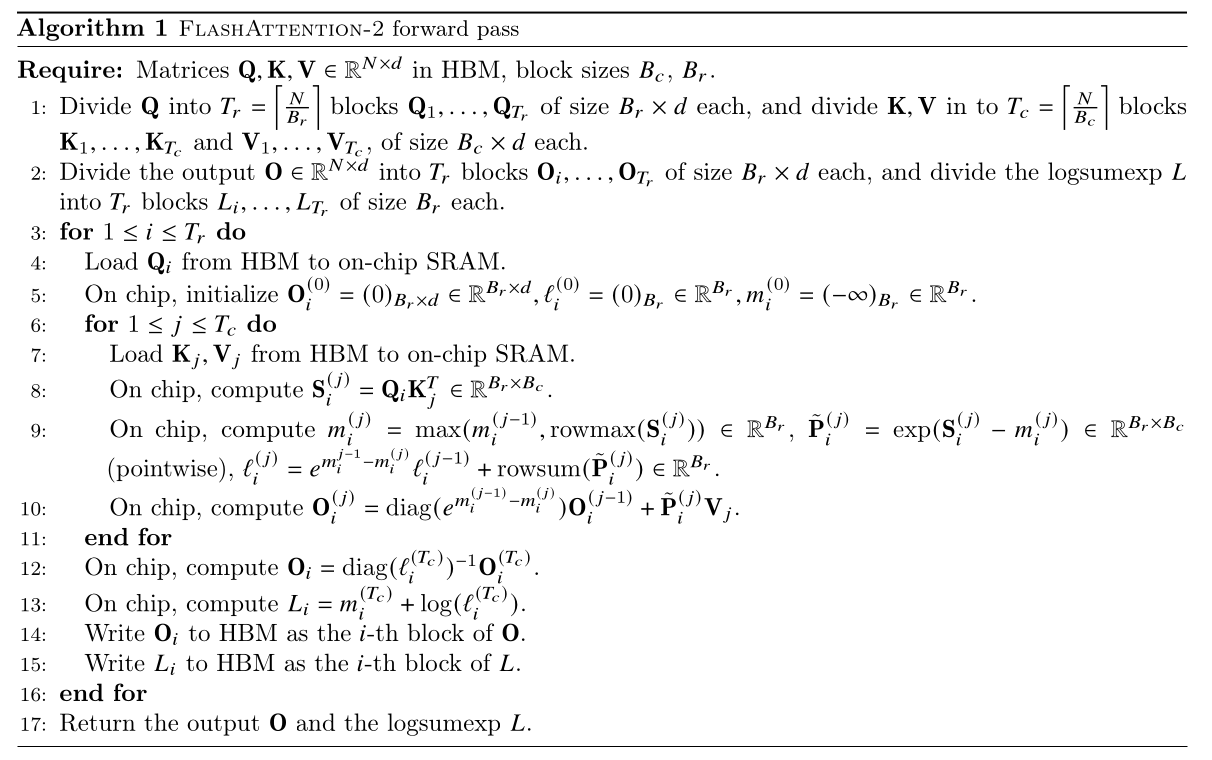

OK, Now we know what to do. Let's import some modules and get a few sample inputs.

In [1]:
import torch, math, itertools, numpy

N_inp = 512
N_out = 512
d = 128

with torch.device("cuda"):
    Q = torch.randn(96, N_out, d)
    K = torch.randn(96, N_inp, d)
    V = torch.randn(96, N_inp, d)

The first thing we do is implement a quite literal translation of the pseudo code into a Python function using tensors for the tiles.
We are not terribly ambitious here and assume that `B_c`and `B_r` divide N_inp and N_out, that N_inp and N_out are actually the same etc.

You might improve the generality (and we welcome your PR).

In [2]:
def flash_attention_reference(Q: torch.Tensor, K: torch.Tensor, V: torch.Tensor, is_causal: bool = False, scale: float | None =None):
    # N.B.: This uses the PyTorch SDPA tensor shape of batch, head_no, seq_len, head_dim
 
    *batch, N_inp, d = K.shape
    *_, N_out, _ = Q.shape

    # assert shape compat
    
    
    O = V.new_zeros(*batch, N_out, d)
    L = V.new_zeros(*batch, N_out, 1)

    dtype = O.dtype
    device = O.device

    neginf = torch.tensor(-math.inf, dtype=Q.dtype, device=Q.device)

    B_c = 16  # this is NOT what the original impl uses
    B_r = 16
    T_c = (N_inp + B_c - 1) // B_c
    T_r = (N_out + B_r - 1) // B_r

    if scale is None:
        scale = 1 / math.sqrt(d)

    for block in itertools.product(*(range(s) for s in batch)):
        # Q and O L split into T_r; K, V in T_c blocks
        for i in range(T_r):
            Q_i = Q[block][i * B_r: (i+1) * B_r]
            O_i = torch.zeros(B_r, d, device=device, dtype=dtype)
            l_i = torch.zeros(B_r, 1, device=device, dtype=dtype)
            m_i = torch.full((B_r, 1), -math.inf, device=device, dtype=dtype)
            last_m_i = m_i
            for j in range(T_c):
                if is_causal and j * B_c > (i+1) * B_r - 1:
                    break
                # in Python 3.11+ we could write K[*block, j * B_c: (j + 1) * B_c] instead...
                K_j = K[block][j * B_c: (j + 1) * B_c]
                V_j = V[block][j * B_c: (j + 1) * B_c]
                S_i = scale * (Q_i @ K_j.T)
                if is_causal and i * B_r < (j + 1) * B_c - 1:
                    mask = torch.arange(i*B_r, (i+1)*B_r, device=device, dtype=dtype)[:, None] >= torch.arange(j*B_c, (j+1) * B_c, device=device, dtype=dtype)[None, :]
                    S_i = torch.where(mask, S_i, neginf)

                m_i = torch.maximum(m_i, S_i.max(dim=-1, keepdim=True).values)
                P_i = torch.exp(S_i - m_i)
                l_i = torch.exp(last_m_i - m_i) * l_i + P_i.sum(dim=-1, keepdim=True)
                O_i = torch.exp(last_m_i - m_i) * O_i + P_i @ V_j
                last_m_i = m_i
            O_i = (1.0 / l_i) * O_i
            L_i = m_i + torch.log(l_i)
            O[block][i * B_r: (i + 1) * B_r] = O_i
            L[block][i * B_r: (i + 1) * B_r] = L_i
    return O, L


Let's see if our function computes the same thing as the PyTorch `scaled_dot_product_attention`.

In [ ]:
actual, _ = flash_attention_reference(Q, K, V)

In [ ]:
expected = torch.nn.functional.scaled_dot_product_attention(Q, K, V)

In [3]:
(actual - expected).abs().max()

tensor(1.3113e-06)

That is neat! But we wanted to write our own CUDA kernel, so let us get out CUDA-Python.

## Using CUDA-Python to compile CUDA kernels for PyTorch

[CUDA-Python](https://github.com/NVIDIA/cuda-python) provides low-level bindings to the CUDA and NVRTC (NVIDIA Run Time Compiler) API. We install it with `pip install cuda-python`.

As those functions are very (I mean extremely) low level, we provide here a couple of helper functions for the following:

- The function `compile_program_and_get_kernel` takes source code and produces a CUDA kernel from it,
- The function `launch_kernel` runs one of our kernels with the specified arguments.

We first import the `cuda` and `nvrtc` modules.

In [4]:
from cuda import cuda, nvrtc

The function `compile_program_and_get_kernel` compiles the source code through NVRTC obtaining a PTX. This
is then loaded (and compiled to SASS by `cuModuleLoadData`).
Quite likely, one would want to let users access some of the other bits (e.g. compile flags), but we have to stop somewhere...


In [5]:
def compile_program_and_get_kernel(cuda_src, function_name):
    """
    Compiles a kernel from the CUDA source code provided in the string `cuda_src` and get the kernel with the name `function_name` (which needs to be
    defined as extern "C" in the CUDA source code).
    
    
    The kernel can then be launched with `launch_kernel`
    """

    def check_error(results):
        err, *results = results
        if isinstance(err, cuda.CUresult):
            if err != cuda.CUresult.CUDA_SUCCESS:
                raise RuntimeError(f"CUDA error: {cuda.cuGetErrorString(err)}")
        elif isinstance(err, nvrtc.nvrtcResult):
            if err != nvrtc.nvrtcResult.NVRTC_SUCCESS:
                raise RuntimeError(f"NVRTC error: {nvrtc.nvrtcGetErrorString(err)}")
        else:
            raise TypeError("Unknown error type: {err}")
        if len(results) == 0:
            return
        if len(results) == 1:
            return results[0]
        return results

    torch.cuda.current_stream()  # this initializes the device context for us. we don't need the stream specifically.
    
    # Create program
    prog = check_error(nvrtc.nvrtcCreateProgram(str.encode(cuda_src), (function_name + '.cu').encode(), 0, [], []))    
    
    # Compile program
    min, maj = torch.cuda.get_device_capability()
    opts = [f"--gpu-architecture=compute_{min}{maj}".encode()] #, b"--expt-relaxed-constexpr"]
    check_error(nvrtc.nvrtcCompileProgram(prog, len(opts), opts))
    
    ## Get PTX from compilation
    ptxSize = check_error(nvrtc.nvrtcGetPTXSize(prog))
    ptx = b" " * ptxSize
    check_error(nvrtc.nvrtcGetPTX(prog, ptx))
    
    logSize = check_error(nvrtc.nvrtcGetProgramLogSize(prog))
    log = b" " * logSize
    check_error(nvrtc.nvrtcGetProgramLog(prog, log))
    print(log.decode())
    #print(ptx.decode())
    
    
    # Load PTX as module data and retrieve function
    module = check_error(cuda.cuModuleLoadData(ptx))
    kernel = check_error(cuda.cuModuleGetFunction(module, function_name.encode()))
    return kernel

Phew. If you're into CUDA programming (I guess you are, but you might check out the [CUDA-MODE](https://github.com/cuda-mode/resource-stream) series if you want to learn more. In fact, this notebooks started as a demo for a [lecture there](https://www.youtube.com/watch?v=zEuwuCTEf_0)), you know that to launch you need to specify block (the number of threads as a 3d "array") and grid (the number of blocks, again as a 3d "array") layout as well as dynamic shared memory.

Another important detail is how we need to pass kernel arguments to `cuLaunchKernel`: We need to set up an array of pointers with the pointers pointing to a (CPU) memory address that contains the parameter (which, in the case of tensors, is a pointer itself). To facilitate having type information, we use numpy scalar types (e.g. `numpy.float32(0.5)`) for the arguments. Note that we don't check whether the kernel actually takes the parameters you give it.


In [6]:
def launch_kernel(kernel, grid, block, /, *args, shmem=0):
    """utility function to launch kernels.
    Args can be tensors (corresponding to float* etc kernel params or numpy scalars (which have precision info))
    """
    
    # collect values (data_ptr as uint64 array for tensors, the values as an array for values)
    addresses = []
    wrapped_args = []
    for a in args:
        if isinstance(a, torch.Tensor):
            # for tensor pass in data_ptr
            wrapped_args.append(numpy.array(a.data_ptr(), dtype=numpy.uint64))
        elif isinstance(a, numpy.number):
            wrapped_args.append(numpy.array([a]))
        else:
            raise TypeError("please only pass tensors and numpy numbers to launch_kernel")
            
    # assemble an array of pointers to the args
    args = numpy.array([a.ctypes.data for a in wrapped_args], dtype=numpy.uint64)

    # set up grid / block layout to be 3d
    grid = tuple(grid)
    block = tuple(block)
    assert 1 <= len(block) <= 3 and 1 <= len(grid) <= 3
    grid = grid + (3 - len(grid)) * (1,)
    block = block + (3 - len(block)) * (1,)
    
    # Launch!
    err, = cuda.cuLaunchKernel(
       kernel,
       *grid, *block, # xyz each
       shmem,  # dynamic shared memory
       torch.cuda.current_stream().stream_id,  # stream
       args.ctypes.data,  # kernel arguments
       0,  # extra (ignore)
    )
    if err != cuda.CUresult.CUDA_SUCCESS:
        raise RuntimeError(f"CUDA error: {err}")

## A native flash attention kernel

With these two done, we can implement our flash attention kernel. As with matmul, the tiling is important. But given head size can be large (128 for LLama-2 7B), using tiles that are large also in the other dimensions puts quite a strain on our on-chip memory resources (we should move to 16 bit floats, really - will you send a PR?).
We put tiles for `Q`, `K`, `V` and `S` (a tile of the matrix of the attention weights or intermediate results for it) in shared memory and `l` and `m` (the denominator of the softmax split as factor and maximum of the log for the stabilization) and `O` tiles into the registers. The other bits are more or less a spelled-out version of the Python version, with a bit more nuisance to implement array operations by spreading across threads and/or loops.

Again, we have many gaps (for shapes that do not divide tile sizes etc. and limitations (no causal yet)), but maybe you find the general idea helpful.


In [7]:
cuda_d = 128
cuda_B_r = 32
cuda_B_c = 16


cuda_src = (
f"""
constexpr int B_r = {cuda_B_r};
constexpr int B_c = {cuda_B_c};
constexpr int d = {cuda_d};
constexpr int o_per_thread_x = 1;
constexpr int o_per_thread_y = 128/32;
"""
    + r"""\
#define NEG_INFINITY __int_as_float(0xff800000)

extern "C" __global__
void silly_attn(float *out, float* out_l, float *K, float *Q, float* V, float scaling, int batch_stride, int T_r, int T_c)
{
  int tid_x = threadIdx.x;
  int tid_y = threadIdx.y;
  int batch_offset = batch_stride * blockIdx.x;

  __shared__ float Q_i[B_r][d];
  __shared__ float K_j[B_c][d];
  __shared__ float V_j[B_c][d];
  
  __shared__ float S_i[B_r][B_c];

  float l_i[o_per_thread_x];
  float m_i[o_per_thread_x];
  float O_i[o_per_thread_x][o_per_thread_y];

  for (int i = 0; i < T_r; i++) {
    for (int ii = 0; ii < o_per_thread_x; ii++) {
      for (int dd = 0; dd < o_per_thread_y; dd++) {
        O_i[ii][dd] = 0;
      }
      l_i[ii] = 0.f;
      m_i[ii] = NEG_INFINITY;
    }
    for (int ii = tid_y; ii < B_r; ii += blockDim.y) {
      for (int dd = tid_x; dd < d; dd += blockDim.x) {
         Q_i[ii][dd] = Q[batch_offset + (ii + i * B_r) * d + dd];
      }
    }
    for (int j=0; j < T_c; j++) {
        __syncthreads();
        for (int jj=tid_y; jj < B_c; jj+= blockDim.y) {
            for (int dd=tid_x; dd < d; dd += blockDim.x) {
                K_j[jj][dd] = K[batch_offset + (jj + j * B_c) * d + dd];
                V_j[jj][dd] = V[batch_offset + (jj + j * B_c) * d + dd];
            }
        }
        __syncthreads();
        // S_i = scale * (Q_i @ K_j.T)
        for (int ii = tid_x; ii < B_r; ii += blockDim.x) {
            for (int jj = tid_y; jj < B_c; jj += blockDim.y) {
                float S_ij = 0.f;
                for (int dd = 0; dd < d; dd++) {
                    S_ij += Q_i[ii][dd] * K_j[jj][dd];
                }
                S_ij = scaling * S_ij;
                S_i[ii][jj] = S_ij;
            }
        }
        __syncthreads();
        for (int ii = 0; ii < o_per_thread_x; ii++) {
            float m = m_i[ii];
            float last_m = m;
            for (int jj = 0; jj < B_c; jj += 1) {
                if (m < S_i[ii * blockDim.x + tid_x][jj]) {
                  m = S_i[ii * blockDim.x + tid_x][jj];
                }
            }
            m_i[ii] = m;
            float l = exp(last_m - m) * l_i[ii];
            for (int dd = 0; dd < o_per_thread_y; dd++) {
                O_i[ii][dd] *= exp(last_m - m);
            }
            
            for (int jj = 0; jj < B_c; jj ++) {
                float S_ij = exp(S_i[ii * blockDim.x + tid_x][jj] - m);
                l += S_ij;
                for (int dd = 0; dd < o_per_thread_y; dd++) {
                    O_i[ii][dd] += S_ij * V_j[jj][dd * blockDim.y + tid_y];
                }
            }
            l_i[ii] = l;

       }
    }
    for (int ii = 0; ii < o_per_thread_x; ii++) {
      for (int dd = 0; dd < o_per_thread_y; dd++) {
        out[batch_offset + (ii * blockDim.x + tid_x + i * B_r) * d + dd * blockDim.y + tid_y] = O_i[ii][dd] / l_i[ii];
        out_l[batch_offset / d +  ii * blockDim.x + tid_x + i * B_r] = l_i[ii];
      }
    }
  }
}
""")


cuda_flash_attention_kernel = compile_program_and_get_kernel(cuda_src, "silly_attn")

cuda_flash_attention_kernel

 


<CUfunction 0xa0cbea0>

With this, we need a wrapper that calls our kernel. This basically prepares inputs and allocates outputs, defines the block and grid layout and calls `launch_kernel`.

In [8]:
def cuda_python_flash_attention(Q: torch.Tensor, K: torch.Tensor, V: torch.Tensor, is_causal: bool = False, scale: float | None =None):
    assert Q.device.type == 'cuda'
    
    if is_causal:
        raise NotImplementedError("cuda_python_flash_attention is_causal=True is not implemented")
    
    *batch, N_inp, d = K.shape
    *_, N_out, _ = Q.shape

    assert d == cuda_d
    
    Q_3d = Q.reshape(-1, N_out, d)
    K_3d = K.reshape(-1, N_inp, d)
    V_3d = V.reshape(-1, N_inp, d)
    
    blocks = Q_3d.shape[0]

    # assert shape compat
    
    O = V.new_zeros(*batch, N_out, d)
    L = V.new_zeros(*batch, N_out, 1)

    O_3d = O.view(-1, N_out, d)
    L_3d = L.view(-1, N_out, 1)
    
    T_c = (N_inp + cuda_B_c - 1) // cuda_B_c
    T_r = (N_out + cuda_B_r - 1) // cuda_B_r

    if scale is None:
        scale = 1 / math.sqrt(d)

    assert N_inp % cuda_B_r == 0  # TODO
    assert N_out == N_inp  # TODO

    GRID = (blocks,)
    BLOCK = (32, 32)

    launch_kernel(cuda_flash_attention_kernel, GRID, BLOCK, O_3d, L_3d, K_3d, Q_3d, V_3d, numpy.float32(scale), 
                  numpy.int32(N_inp * d), numpy.int32(T_r), numpy.int32(T_c))
    return O, L


Qc = Q.cuda()
Kc = K.cuda()
Vc = V.cuda()

actual, _ = cuda_python_flash_attention(Qc, Kc, Vc)
expected = torch.nn.functional.scaled_dot_product_attention(Qc, Kc, Vc)

(actual - expected).abs().max()


tensor(1.8477e-06, device='cuda:0')

So how slow is it? Quite a lot slower. Depending on the input sizes, this can be an order of magnitude.
But hey, it's an optimization opportunity.

In [9]:
%timeit torch.nn.functional.scaled_dot_product_attention(Qc, Kc, Vc); torch.cuda.synchronize()
%timeit cuda_python_flash_attention(Qc, Kc, Vc); torch.cuda.synchronize()

1.1 ms ± 741 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
14.9 ms ± 1.22 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Running our kernel in Thunder

We want to have our kernel handle calls to `scalar_dot_product_attention` where it applies.
Fortunately, this is much easier than getting the kernel itself.

We start with having our own executor.

## Create a thunder executor

We create an `OperatorExecutor` and register it as a default executor.


In [10]:
import thunder

attn_ex = thunder.extend.OperatorExecutor('attn_ex', version=0.01)
thunder.add_default_executor(attn_ex)

[attn_ex, sdpa, nvfuser]

## Register our implementation as an operator

The next thing we do is to register our implementation as an executor. We use our implementation above for the execution function (the `fn` parameter) and proivde a short meta describing the result metadata as determined by the input metadata. 

In [11]:
def my_attn_meta(query, key, value, is_causal, scale):
    return thunder.TensorProxy(like=query), thunder.TensorProxy(like=query, shape=(*query.shape[:1], 1))

my_attn = attn_ex.register_operator('my_attn', meta=my_attn_meta, fn=cuda_python_flash_attention)

## Register our attention as an implementation of torch sdpa

But to have Thunder automatically use our implementation we need to tell it that it implements sdpa.
Our checker function takes the same arguments as PyTorch sdpa and returns `True` or `False` depending on whether our implementation applies. It makes sure we do not take variants we do not support in our implementation (non-cuda, or with causal or bespoke marking or dropout).

The execution transform is also just a function that again takes the same inputs as PyTorch sdpa but has the same returns as well. The function itself is very basic, just calling the symbol we registered with Thunder.

If we had a backward, we could not register a grad transform with `register_implementation` as well (see the [zero to thunder tutorial](./zero_to_thunder.ipynb) or the [extending thunder tutorial](./dev_tutorials/extend.ipynb) for an example with grad transform.


In [12]:
def my_attn_checker(query, key, value, attn_mask=None, dropout_p=0.0, is_causal=False, scale=None):
    if attn_mask is not None or dropout_p != 0.0 or is_causal:
        return False
    return (query.device.devicetype == thunder.devices.DeviceType.CUDA and
            key.device == query.device and
            value.device == query.device)

def my_attn_transform(query, key, value, attn_mask=None, dropout_p=0.0, is_causal=False, scale=None):
    if scale is None:
        d = query.shape[-1]
        scale = d**(-0.5)
    out = my_attn(query, key, value, is_causal, scale)
    return out[0]


attn_ex.register_implementation(thunder.torch.scaled_dot_product_attention, checker=my_attn_checker,
                                execution_transform=my_attn_transform)

## Run...

Now we are ready to run models with our implementation. To keep things simple, we just use a function calling the PyTorch attention function, but you could also use your favourite LLM from [LitGPT](https://github.com/Lightning-AI/litgpt) here.

In [13]:
def test_fn(query, key, value):
    return torch.nn.functional.scaled_dot_product_attention(query, key, value, is_causal=False)

jfn = thunder.jit(test_fn)

print((jfn(Qc, Kc, Vc) - test_fn(Qc, Kc, Vc)).abs().max())

tensor(1.8477e-06, device='cuda:0')


# Inspect

Using `thunder.last_traces` we can look at what happened. The last trace in the list returned by this function is the fully transformed program and uses our new function. 

In [14]:
print(thunder.last_traces(jfn)[-1])

# Constructed by Delete Last Used (took 0 milliseconds)
import torch
from thunder.executors.torchex import no_autocast

@torch.no_grad()
@no_autocast()
def computation(query, key, value):
  # query: "cuda:0 f32[96, 512, 128]"
  # key: "cuda:0 f32[96, 512, 128]"
  # value: "cuda:0 f32[96, 512, 128]"
  (t13, _) = my_attn(query, key, value, False, 0.08838834764831845)
  del query, key, value
  return t13


The first trace contains the program as captured by Thunder, so it still has the call to PyTorch SDPA that is then translated. 

In [15]:
print(thunder.last_traces(jfn)[0])

import thunder
import thunder.torch as ltorch
import torch
from thunder.executors.torchex import no_autocast

@torch.no_grad()
@no_autocast()
def computation(query, key, value):
  # query: "cuda:0 f32[96, 512, 128]"
  # key: "cuda:0 f32[96, 512, 128]"
  # value: "cuda:0 f32[96, 512, 128]"
  t13 = ltorch.scaled_dot_product_attention(query, key, value, None, 0.0, False, scale=None)  # t13: "cuda:0 f32[96, 512, 128]"
    # t0 = ltorch.mul(query, 0.29730177875068026)  # t0: "cuda:0 f32[96, 512, 128]"
      # t0 = prims.mul(query, 0.29730177875068026)  # t0: "cuda:0 f32[96, 512, 128]"
    # t1 = ltorch.transpose(key, -2, -1)  # t1: "cuda:0 f32[96, 128, 512]"
      # t1 = prims.transpose(key, (0, 2, 1))  # t1: "cuda:0 f32[96, 128, 512]"
    # t2 = ltorch.mul(t1, 0.29730177875068026)  # t2: "cuda:0 f32[96, 128, 512]"
      # t2 = prims.mul(t1, 0.29730177875068026)  # t2: "cuda:0 f32[96, 128, 512]"
    # t3 = ltorch.matmul(t0, t2)  # t3: "cuda:0 f32[96, 512, 512]"
      # t3 = prims.matmul(t0,

# Comparing implementations

If we want to compare implementations, we can also compile the function without our executor to get the "default" implementation.

In [16]:
jfn_without_attn_ex = thunder.jit(test_fn, executors=[thunder.sdpa_executor, thunder.nvfuser_executor])

print((jfn(Qc, Kc, Vc) - jfn_without_attn_ex(Qc, Kc, Vc)).abs().max())

tensor(1.8477e-06, device='cuda:0')


In [17]:
%timeit jfn(Qc, Kc, Vc) ; torch.cuda.synchronize()
%timeit jfn_without_attn_ex(Qc, Kc, Vc) ; torch.cuda.synchronize()


15 ms ± 48 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.12 ms ± 1.52 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


And, of course, we can also see this by inspecting the traces:

In [18]:
print(thunder.last_traces(jfn_without_attn_ex)[-1])

# Constructed by Delete Last Used (took 0 milliseconds)
import torch
import torch.nn.functional
from thunder.executors.torchex import no_autocast

@torch.no_grad()
@no_autocast()
def computation(query, key, value):
  # query: "cuda:0 f32[96, 512, 128]"
  # key: "cuda:0 f32[96, 512, 128]"
  # value: "cuda:0 f32[96, 512, 128]"
  t13 = torch.nn.functional.scaled_dot_product_attention(query, key, value, None, 0.0, False, scale=None)  # t13: "cuda:0 f32[96, 512, 128]"
    # t13 = ltorch.scaled_dot_product_attention(query, key, value, None, 0.0, False, scale=None)  # t13: "cuda:0 f32[96, 512, 128]"
      # t14 = ltorch.mul(query, 0.29730177875068026)  # t14: "cuda:0 f32[96, 512, 128]"
        # t14 = prims.mul(query, 0.29730177875068026)  # t14: "cuda:0 f32[96, 512, 128]"
      # t15 = ltorch.transpose(key, -2, -1)  # t15: "cuda:0 f32[96, 128, 512]"
        # t15 = prims.transpose(key, (0, 2, 1))  # t15: "cuda:0 f32[96, 128, 512]"
      # t16 = ltorch.mul(t15, 0.29730177875068026)  # t16: "c

# Summary

So that is it.

What did we achieve?

- We implemented a kernel following the flash-attention 2 pseudocode (but not having all the optimizations) in CUDA.
- Then we looked at how to compile and run it using the NVIDIA CUDA-Python bindings.
- Finally, we saw how Thunder executors make it easy run PyTorch programs with targeted optimizations.

We hope that you do great things and may your kernels always turn out to be faster than the baseline!